In [23]:
#Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
import time

In [24]:
#Getting the data
path = '../data-unversioned'
cf10 = datasets.CIFAR10(path, train= True, download= True)
cf10_val = datasets.CIFAR10(path, train= False, download= True)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


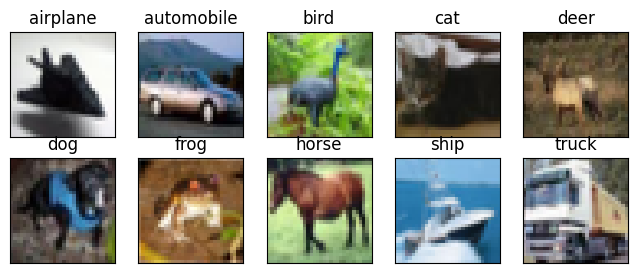

In [26]:
#Display Classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig1 = plt.figure(figsize=(8,3))
class_size = 10
for i in range(class_size):
    plt1 = fig1.add_subplot(2, 5, 1 + i, xticks= [], yticks= [])
    plt1.set_title(classes[i])
    image = next(image for image, label in cf10 if label == i)
    plt.imshow(image)
plt.show()

In [27]:
#Grabbing Datasets as a tensor
cf10_ten = datasets.CIFAR10(path, train= True, download= False, transform= transforms.ToTensor())
imTen, _ = cf10_ten[99]
#imTen.shape, imTen.dtype

#Image Stacking
Stacked_images = torch.stack([imTen for imTen, _ in cf10_ten], dim= 3)
Stacked_images = torch.flatten(Stacked_images)
Stacked_images.shape

torch.Size([153600000])

In [28]:
#Re-Grabbing data to normalize
transCF10 = datasets.CIFAR10(path, train= True, download= False, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
transCF10_val = datasets.CIFAR10(path, train= False, download= False, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [29]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []
val_accuracy_list = []
all_predicted = []
all_labels = []

def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for Stacked_images, labels in training_loader:
      Stacked_images = Stacked_images.to(device)
      labels = labels.to(device)
      outputs = model(Stacked_images)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    train_loss_list.append(loss_train / len(training_loader)) 

    
    #Validation Loop
    correct = 0
    total = 0
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          all_predicted.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

    val_loss_list.append(valid_loss / len(valid_loader))
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader)))

In [30]:
# AlexNet

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [31]:
model = AlexNet(num_classes= 10).to(device) 
a = 0.01
epochs = 20
lossFN = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= a)
training_loader = torch.utils.data.DataLoader(transCF10, batch_size= 64, shuffle= True)
valid_loader = torch.utils.data.DataLoader(transCF10_val, batch_size= 64, shuffle= True)
start_time = time.time()

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= model,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader
)

#Getting the time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time/60} Minutes")

Epoch: 1, Training Loss: 2.302015850915933, Validation Loss: 2.30042675042608
Epoch: 5, Training Loss: 1.5956318703148982, Validation Loss: 1.5726277828216553
Epoch: 10, Training Loss: 1.1360212933376928, Validation Loss: 1.2291287365992358
Epoch: 15, Training Loss: 0.8670605268624737, Validation Loss: 0.9077479490049326
Epoch: 20, Training Loss: 0.6655845155420206, Validation Loss: 0.9009900757461596
Time taken: 14.547688126564026 Minutes


In [32]:
# Calculate and print the accuracy
accuracy = val_accuracy_list[-1]
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print precision, recall, and F1 score
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Save the model weights
#torch.save(model.state_dict(), './model/DLHW1P1B.pth')  # .pth is the recommended extension

#Complexity
numel_list = [p.numel() for p in model.parameters()]
print("Model Complexity: {}".format(sum(numel_list)))
#sum(numel_list), numel_list

Accuracy: 0.6880
Precision: 0.5162
Recall: 0.5137
F1 Score: 0.5087
Model Complexity: 57026378


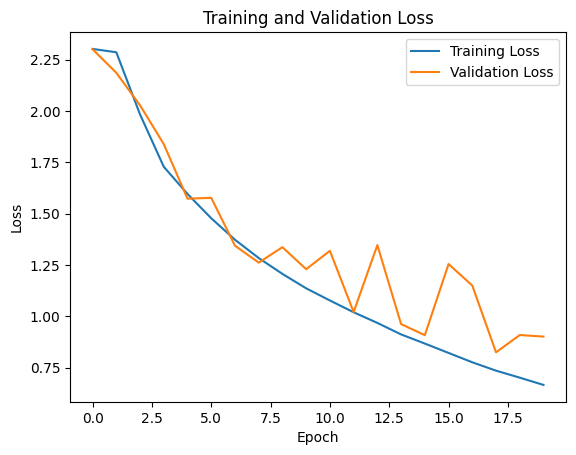

In [33]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/LeNet_training_validation_loss.png')
plt.show()